Import/Clean

In [22]:


# import packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time
start_time = time.time()

# import and clean data
df = pd.read_csv("data/kaggle_data.csv")

# sample on small data set - COMMENT OUT
# sampled_hosts = df['host'].drop_duplicates().sample(frac=0.25, random_state=42)
# df = df[df['host'].isin(sampled_hosts)]

# drop redundant columns and convert time from Unix to datetime
df = df.drop('Unnamed: 0',axis=1)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Clean up our url data we will be clustering over
# we have bad data where the url is just '/'
df = df[df['url']!='/']

# we need to filter to get requests only that were also successful.
df = df[(df['method']=='GET') & (df['response'] == 200)]

# obtain our directory column from url
df['directory'] = df['url'].apply(lambda x: x.lstrip('/').split('/')[0])

Feature creation

In [23]:
""" Methodology.
 Create feature "importance" - reflects how well this data point mirrors the user's personal interest
 1. determine time spent on each url
 2. how recently this url was accessed by user
 3. calc importance by weighting time spent on url by recency of url access
 4. normalise importance
 """

# 1. Time Spent on URL
# calculate time spent on each url for each user
# sort by host and time
df = df.sort_values(by=['host','time'], ascending=True)
df['next_time'] = df.groupby('host')['time'].shift(-1)
df['time_spent'] = (df['next_time']-df['time']).dt.total_seconds()

# if the time spent is >30 minutes, we assume they left and assign it null
df['time_spent'] = df['time_spent'].mask(df['time_spent'] > 1800, None)

# if last page of the session, set time spent to null
df['time_spent'] = df['time_spent'].mask(df['next_time'].isna(), None)

# drop the nulls
df = df.dropna(subset=['time_spent'])

# some have time spent is 0. Not relevant and breaks 0 division later when normalising
df = df[df['time_spent']!=0]


# 2. How recently url was accessed per host (relative to most recent access)
# e.g. if visited a website more recently, we assume they are more interested in this than website visited a month ago
df['recency'] = df.groupby('host')['time'].transform(lambda x: (x.max() - x).dt.total_seconds())

# convert this into weighting factor - use exponential decay. Set decay rate so we are at e^-1 ~ 0.37 after 4 weeks
decay_factor = 60*60*24*7*31 # 31 days
df['weight'] = np.exp(-df['recency'] / decay_factor)

# 3. Calc importance by weighting time spent on url by recency of url access. Also normalise
df['importance'] = df['weight']*df['time_spent']
# normalise this importance per host
df['norm_importance'] = df.groupby('host')['importance'].transform(lambda x: x/(x.sum()))



Aggregate importance per user per directory. Do KMeans clusstering

In [24]:
# convert to pivot table. Each row is the distribution of the host's "importance" normalised
weighted_features = df.pivot_table(index='host', columns='directory', values='norm_importance', aggfunc='sum', fill_value=0)
# Drop columns where all values are zero
weighted_features = weighted_features.loc[:, (weighted_features != 0).any(axis=0)]


# Do KMeans clustering
X = weighted_features

# K-means clustering - choose 4 ... don't want to have to do too much personalisation.
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# add cluster label
weighted_features['cluster'] = clusters

Analysis of clustering results

In [25]:
# rejoin to original df and analyse the preferences of each cluster using importance metric
host_cluster_map = weighted_features[['cluster']].reset_index() #reset index converts 'host' from index to column
df = df.merge(host_cluster_map, on='host')

# analyse preferences by pivoting by cluster, summing and normalising importance per cluster
# we now have a view of each clusters "preferences" in ratio
cluster_directory_weights = df.pivot_table(index='cluster', columns='directory', values='norm_importance', aggfunc='sum', fill_value=0)
cluster_directory_weights = cluster_directory_weights.div(cluster_directory_weights.sum(axis=1), axis=0)


Visualise results

Top 2 most common directories for each cluster:
cluster
0     [history, images]
1     [images, shuttle]
2     [shuttle, images]
3    [software, images]
dtype: object

Weights of the top 2 most common directories for each cluster:
cluster
0    [0.78, 0.11]
1    [0.79, 0.11]
2     [0.8, 0.13]
3     [0.25, 0.2]
dtype: object


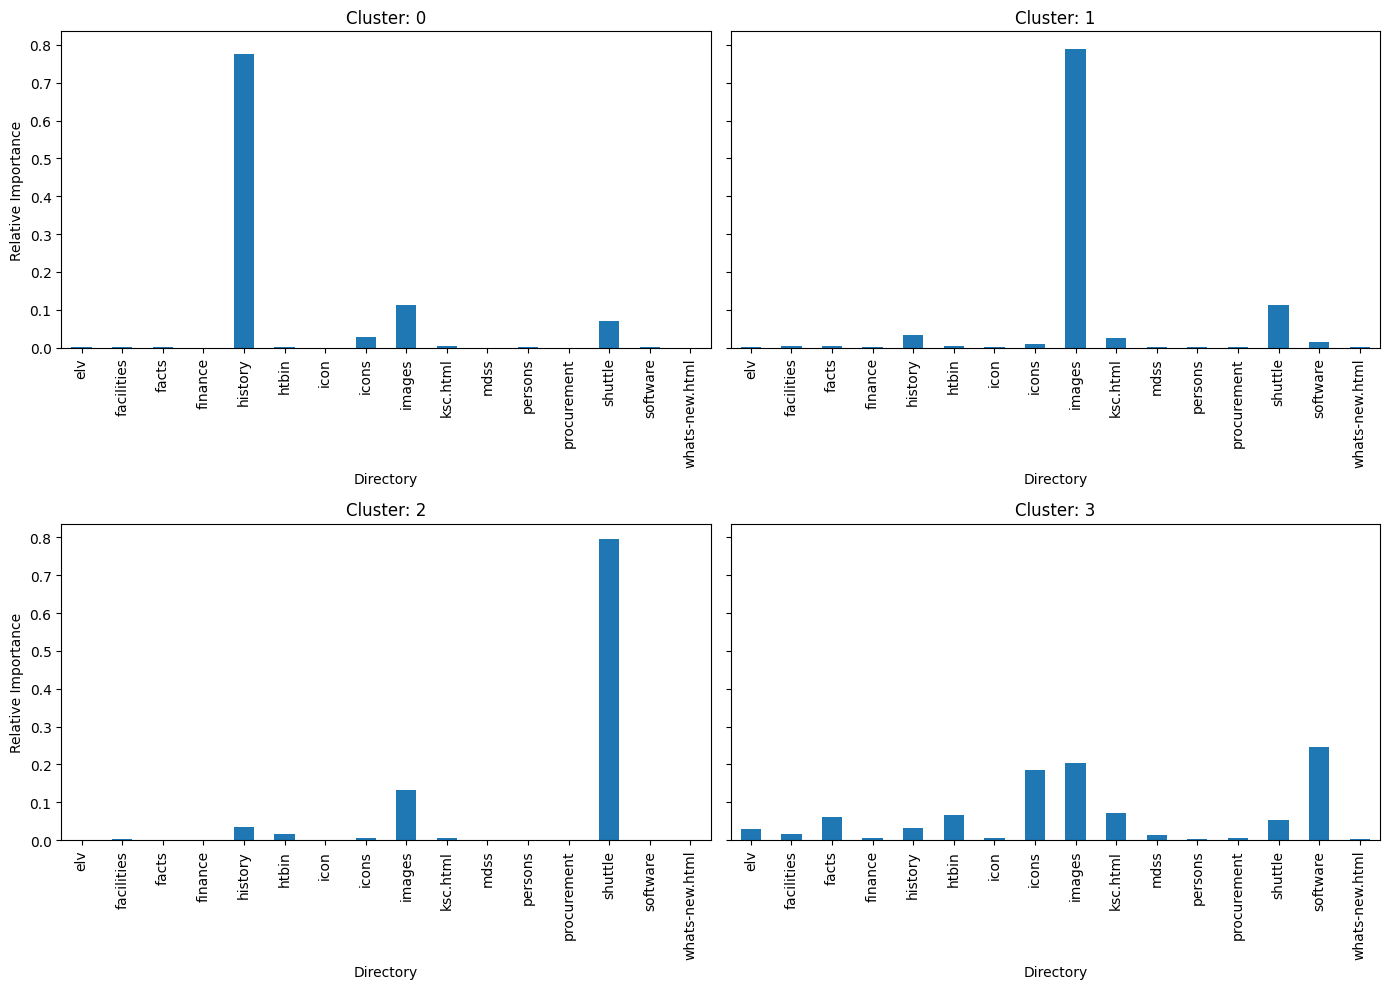

Total runtime: 109.42 seconds


In [26]:
# Find the top 2 most common directories for each cluster
top_2_directories = cluster_directory_weights.apply(lambda x: x.nlargest(2).index.tolist(), axis=1)
top_2_weights = cluster_directory_weights.apply(lambda x: [round(value,2) for value in x.nlargest(2).values.tolist()], axis=1)


# know the proportions of relative importance

print("Top 2 most common directories for each cluster:")
print(top_2_directories)

print("\nWeights of the top 2 most common directories for each cluster:")
print(top_2_weights)

# plot the distribution of importance for each cluster
# Plotting the bar graphs
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, cluster in enumerate(cluster_directory_weights.index):
    ax = axes[i]
    cluster_directory_weights.loc[cluster].plot(kind='bar', ax=ax)
    ax.set_title(f"Cluster: {cluster}")
    ax.set_xlabel('Directory')
    ax.set_ylabel('Relative Importance')

plt.tight_layout()
plt.show()

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

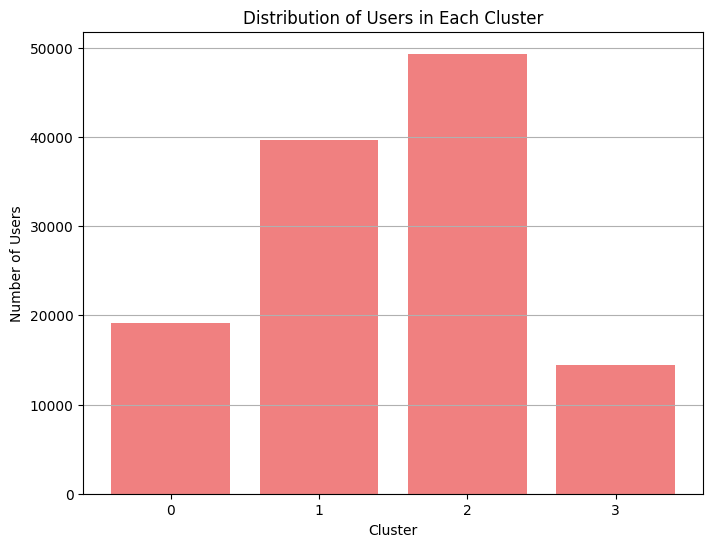

In [31]:
cluster_distribution = weighted_features['cluster'].value_counts().sort_index()
# Convert the distribution to a DataFrame for better visualization
cluster_distribution_df = cluster_distribution.reset_index()
cluster_distribution_df.columns = ['cluster', 'number_of_users']

# Plotting the distribution
plt.figure(figsize=(8, 6))
plt.bar(cluster_distribution_df['cluster'], cluster_distribution_df['number_of_users'], color= 'lightcoral')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Distribution of Users in Each Cluster')
plt.xticks(cluster_distribution_df['cluster'])
plt.grid(axis='y')
plt.show()